# Feature Manipulation, Tranformation, & Normalization

### This notebook contains feature manipulation based on the initial exploratory data analysis in preparation for regression analysis, as well as subsequent transformation and normalization in preparation for fitting the data with a model to predict the sale prices of the test data set.

The EDA was done in R, but the regression analysis will shift to Python, and the subsequent machine learning analysis will also use Python, so let's do all the feature manipulation in Python as well.

In [1]:
# First load revelant libraries:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### Training data feature manipulation, transformation, & normalization

In [2]:
# Load data (already downloaded and saved locally)
train_with_extra_NA = pd.read_csv('train.csv')
# Drop NA values from columns: LotFrontage, Electrical, MasVnrType, MasVnrArea
train_with_NA = train_with_extra_NA.dropna(subset = ['LotFrontage','Electrical','MasVnrType','MasVnrArea'])
# Remove outliers from LotFrontage, LotArea, and GrLivArea
train_sct_trim = train_with_NA.loc[((train_with_NA['LotFrontage'] < 300) &
                                    (train_with_NA['LotArea'] < 200000) &
                                    (train_with_NA['GrLivArea'] < 4500))]

In [3]:
# Check where remaining NA are
train_sct_trim.columns[train_sct_trim.isna().any()].tolist()

['Alley',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

Start by defining a few useful data visualization functions:

In [4]:
# Define function to convert the column names in the data file into more human parsable labels
# Import from .csv file created from list developed during EDA, rather than retyping entire list again
def axis_label(column):
    axis_labels_from_csv = pd.read_csv('Axis_labels.csv')
    axis_label_dict = dict(axis_labels_from_csv.values)
    if column in axis_label_dict:
        axis_label = axis_label_dict.get(column)
    else:
        axis_label = column
    return axis_label

In [5]:
# Some additional functions for plotting
# Plot single histogram:
def hist_plot_column(data, column, bins = 40):
    sns.set(rc={'figure.figsize':(10,8)})
    hist_plot = sns.histplot(data = data, x = column, bins = bins)
    plt.xlabel(axis_label(column))
    return hist_plot

# Plot an 2 column wide array of histograms from a list of columns:
def hist_multi_plot(data, column_list, num_columns = 2, bins = 40):
    if len(column_list) % num_columns == 0:
        num_rows = len(column_list) // num_columns
    else:
        num_rows = len(column_list) // num_columns + 1
    fig, ax = plt.subplots(nrows = num_rows, ncols = num_columns, figsize = (22,num_rows * 9))
    for i, column in enumerate(column_list):
        plt.subplot(num_rows, num_columns, i+1)
        hist_plot_column(data, column)

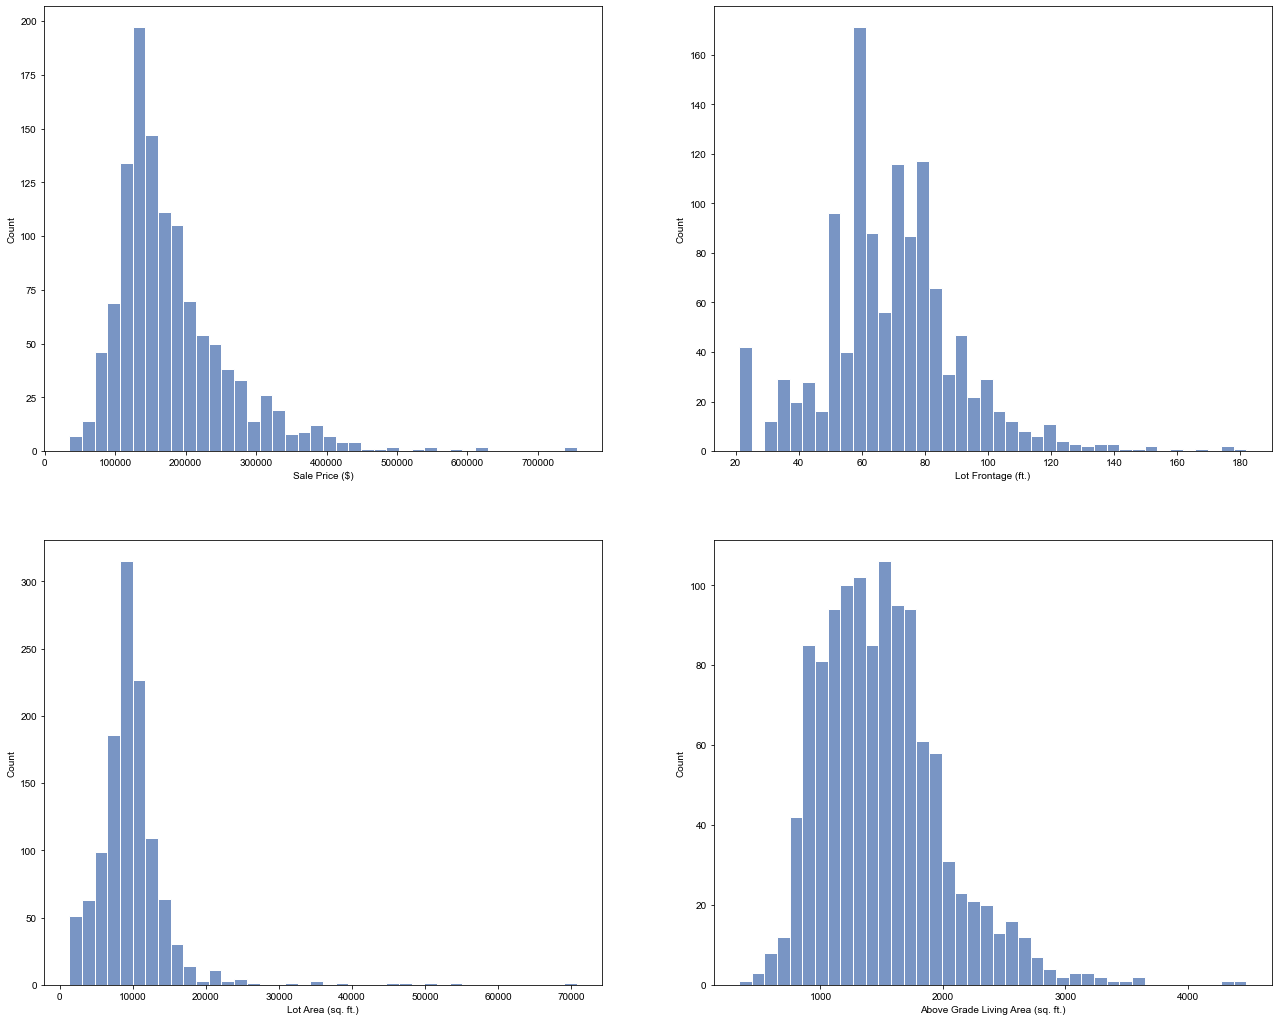

In [6]:
plot_column_list = ['SalePrice','LotFrontage','LotArea','GrLivArea']
hist_multi_plot(train_sct_trim, plot_column_list)

These are all skewed and will require transformation. Let's use log10 to tranform these so that the distributions are closer to normal distributions.
<br>First select the features of interest:

In [7]:
# Define column lists of interest:
transform_column_list = ['SalePrice','LotFrontage','LotArea','GrLivArea']
response = ['SalePrice']
continuous_var = ['LotFrontage','LotArea','YearBuilt','GrLivArea']
category_var = ['MSZoning',
                'Alley',
                'LotShape',
                'LotConfig',
                'Neighborhood',
                'Condition1',
                'RoofStyle',
                'BldgType',
                'HouseStyle',
                'Exterior1st',
                'MasVnrType',
                'Foundation',
                'BsmtQual',
                'CentralAir',
                'Electrical',
                'FullBath',
                'Fireplaces',
                'GarageType',
                'MoSold',
                'SaleType']
normalize_column_list = response + continuous_var
# Remove unused features
train_trunc = train_sct_trim[response + continuous_var + category_var]

Now the log10 transformation:

In [8]:
# Transform continuous features other than YearBuilt
train_log10 = train_trunc.copy()
for trans_column in transform_column_list:
    train_log10[trans_column] = np.log10(train_trunc[trans_column])

...and replot transformed variables:

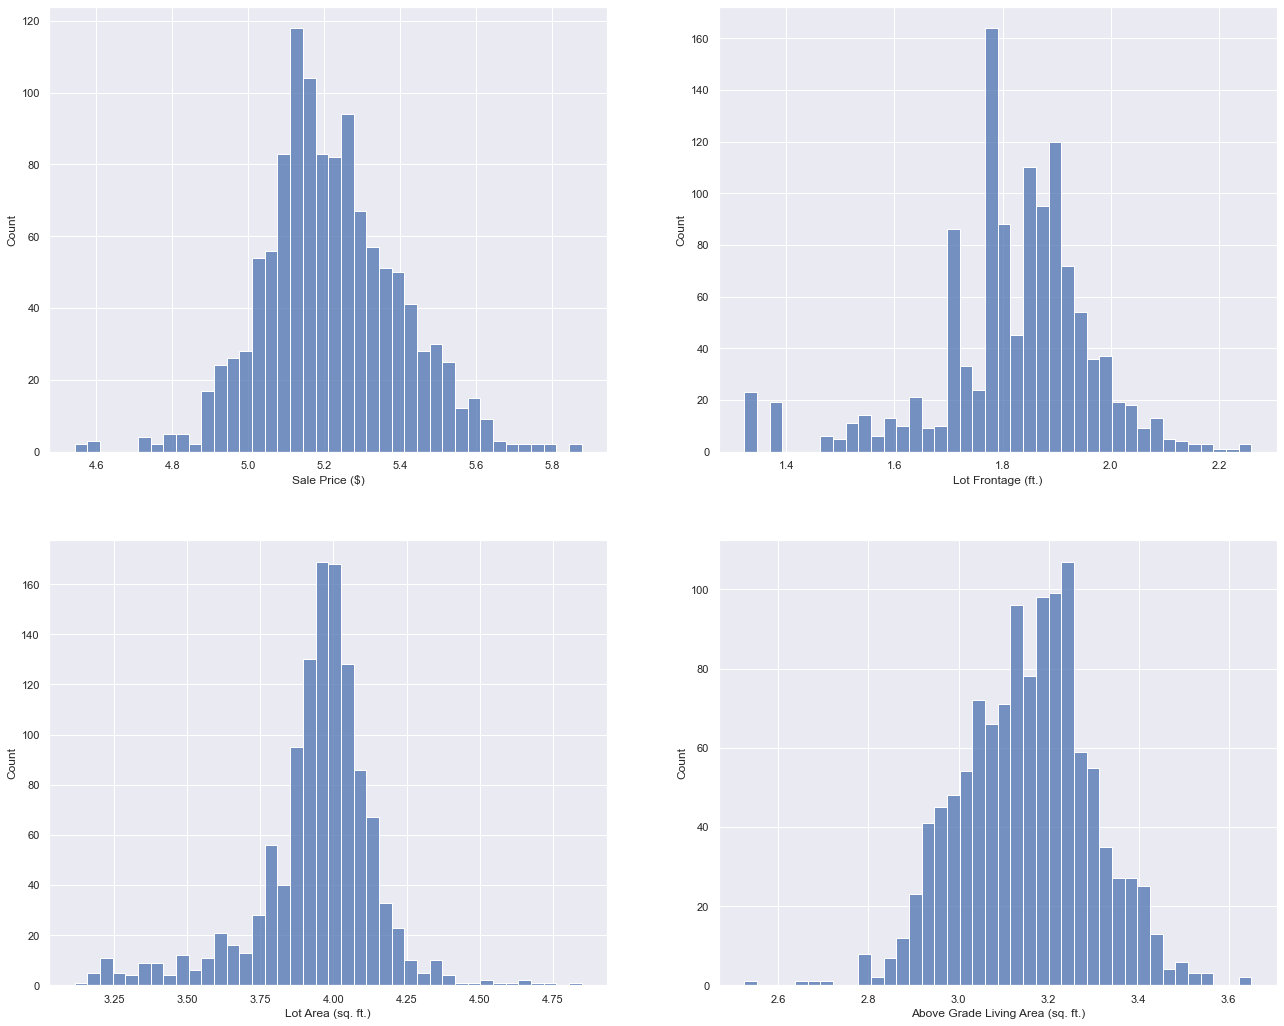

In [9]:
hist_multi_plot(train_log10, plot_column_list)

These look better.

Next the continuous features and response should be normalized so that all values are between 0 and 1 (also store the unencoded values for later use with test data set):

In [10]:
# Normalize all continuous features
train_norm = train_log10.copy()
train_col_norm_min = pd.Series(dtype = 'float64') # create empty series to store min/max values in
train_col_norm_max = pd.Series(dtype = 'float64')
for norm_column in normalize_column_list:
    min_col = min(train_log10[norm_column])
    max_col = max(train_log10[norm_column])
    train_norm[norm_column] = ((train_log10[norm_column] - min_col)/(max_col - min_col))
    train_col_norm_min = pd.concat([train_col_norm_min, pd.Series(min_col)], ignore_index = True) # concat values into pre-defined series
    train_col_norm_max = pd.concat([train_col_norm_max, pd.Series(max_col)], ignore_index = True)
train_col_norm = pd.concat([train_col_norm_min, train_col_norm_max], axis = 1)
train_col_norm = train_col_norm.rename(index = dict((key, value) for key, value in enumerate(normalize_column_list)),
                      columns = {0:'min', 1:'max'}) # relabel index / columns for better parsability
train_col_norm.to_csv(path_or_buf = 'train_col_norm.csv', index = True) # save as .csv file for use later with the test data set

That will handle the continuous features, but the categorical features remain. As was seen in the EDA, some of the features have levels with a very low number of samples in them, so it seems prudent to combine similar categories wherever possible before encoding.

In [11]:
# Adjust categorical variable feature levels
# MSZoning use as-is
train_levels = train_norm.copy()
train_levels['Alley'] = train_levels['Alley'].replace(to_replace = np.nan, value = 'No Alley') # replace NA values with understandable text string
train_levels['LotShape'] = train_levels['LotShape'].replace(to_replace = ['IR1','IR2','IR3'], value = 'Irr') # replace irregular types with single irregular
train_levels['LotConfig'] = train_levels['LotConfig'].replace(to_replace = ['FR2','FR3'], value = 'FR2+') # combine categories with frontage into one category
# Neighborhood use as-is
Cond1_rep = dict.fromkeys(['RRNn','RRAn','RRNe','RRAe'],'RR')
Cond1_rep.update(dict.fromkeys(['PosN','PosA'],'Pos'))
train_levels['Condition1'] = train_levels['Condition1'].replace(Cond1_rep) # consolidate railroad and positive categories
# BldgType use as-is
train_levels['HouseStyle'] = train_levels['HouseStyle'].replace({'1.5Fin':'1.5Story','1.5Unf':'1.5Story','2.5Fin':'2.5Story','2.5Unf':'2.5Story'}) # consolidate some categories
train_levels['RoofStyle'] = train_levels['RoofStyle'].replace({'Flat':'Gable','Gambrel':'Gable','Mansard':'Hip'}) # consolidate similiar roof categories
train_levels['Exterior1st'] = train_levels['Exterior1st'].replace({'BrkFace':'Brick',
                                                                   'BrkComm':'Brick',
                                                                   'ImStucc':'Stucco',
                                                                   'WdShing':'Wood',
                                                                   'Wd Sdng':'Wood',
                                                                   'AsbShng':'Other',
                                                                   'AsphShn':'Other',
                                                                   'CBlock':'Other',
                                                                   'Stone':'Other'}) # consolidate exterior siding by material explicitly
train_levels['MasVnrType'] = train_levels['MasVnrType'].replace(['BrkFace','BrkCmn'],'Brick') # combine brick categories
train_levels['Foundation'] = train_levels['Foundation'].replace(['Slab','Stone','Wood'],'Other') # consolidate several low frequency categories
train_levels['BsmtQual'] = train_levels['BsmtQual'].replace({'Ex':'100+ inches',
                                                             'Gd':'90-99 inches',
                                                             'TA':'80-89 inches',
                                                             'Fa':'70-79 inches',
                                                             np.nan: 'None'}) # replace non-descriptive category names with descriptions from documentation
# CentralAir use as as-is
train_levels['Electrical'] = train_levels['Electrical'].replace(['FuseA','FuseF','FuseP','Mix'],'Fuse') # consolidate fuse categories
train_levels['FullBath'] = train_levels['FullBath'].replace({0:'1-',1:'1-',2:'2+',3:'2+'}) # consolidate full bath options (also 0 full batch above grade seems strange)
train_levels['Fireplaces'] = train_levels['Fireplaces'].replace({0:'No',1:'Yes',2:'Yes',3:'Yes'}) # consolidate Fireplace counts into binary variable
train_levels['GarageType'] = train_levels['GarageType'].replace({'CarPort':'Other','Basment':'Other','2Types':'Other',np.nan:'None'}) # consolidate some low frequency categories and also address NA
# MoSold: (dtype is int64) use as-is
train_levels['SaleType'] = train_levels['SaleType'].replace({'CWD':'WD','ConLD':'Con','ConLI':'Con','ConLW':'Con'}) # consolidate some similar categories

train_levels.to_csv(path_or_buf = 'train_feature_levels.csv', index = False) # save train feature levels as .csv for use later comparing to test data set

The categorical features can now be encoded using Pandas get_dummies to create dummy varibles for each feature level:

In [12]:
# Encode categorical variables
train_encoded = pd.get_dummies(train_levels, columns = category_var, drop_first = True) # this is sufficient for a linear regression with first order terms; save below as .csv

Additional columns are needed for the second-order (e.g. feature<sup>2</sup>) and interaction (feature<sub>1</sub> * feature<sub>2</sub>) terms for use in the model that will fit these variables. These can be created in a separate dataframe:

In [13]:
# Create columns corresponding to second order and interaction terms for use creating regressions using same
train_sec_order = train_encoded.copy()
for i, cont_feature_sec in enumerate(continuous_var):
    train_sec_order[cont_feature_sec + '^2'] = train_encoded[cont_feature_sec] ** 2
    if (i + 1) < len(continuous_var):
        continuous_var_int = continuous_var[(i+1):len(continuous_var)]
        for cont_feature_int in continuous_var_int:
            train_sec_order[cont_feature_sec + ' + ' + cont_feature_int] = train_encoded[cont_feature_sec] * train_encoded[cont_feature_int]
    else:
        break

Now the appropriate starting dataframes can be saved as .csv files to be imported fresh for each model:

In [14]:
# Save appropriate dataframes as .csv files
train_encoded.to_csv(path_or_buf = 'train_linear.csv', index = False) # save .csv with linear terms only
train_sec_order.to_csv(path_or_buf = 'train_sec_order.csv', index = False) # save .csv with second order and interaction terms

#### Test data feature manipulation, transformation, & normalization

In order to predict a response (sale price) using the test data, the inputs for the features in the test data set all need to be manipulated, transformed, and normalized in the same manner as the training data set.

In [15]:
# Import test data set:
test = pd.read_csv('test.csv')

In [16]:
# Define column lists of interest
transform_column_list = ['LotFrontage','LotArea','GrLivArea']
continuous_var = ['LotFrontage','LotArea','YearBuilt','GrLivArea']
category_var = ['MSZoning',
                'Alley',
                'LotShape',
                'LotConfig',
                'Neighborhood',
                'Condition1',
                'RoofStyle',
                'BldgType',
                'HouseStyle',
                'Exterior1st',
                'MasVnrType',
                'Foundation',
                'BsmtQual',
                'CentralAir',
                'Electrical',
                'FullBath',
                'Fireplaces',
                'GarageType',
                'MoSold',
                'SaleType']
normalize_column_list = continuous_var

# Remove unused features
test_trunc = test[continuous_var + category_var]

In [17]:
# Check where remaining NA are
test_trunc.columns[test_trunc.isna().any()].tolist()

['LotFrontage',
 'MSZoning',
 'Alley',
 'Exterior1st',
 'MasVnrType',
 'BsmtQual',
 'GarageType',
 'SaleType']

Most of those columns should not have NA values. These will need to be dealt with before the test data can be used for predictions. Note that unlike the training data set, these NA values cannot simply be dropped, since we need to predict a sale price for that house. <br>
First, let's handle LotFrontage:

In [18]:
# Replace NaN values in LotFrontage column with median value
med_lotfrontage = test_trunc.LotFrontage.median()
test_LF_NaN = test_trunc.copy()
test_LF_NaN['LotFrontage'] = test_LF_NaN['LotFrontage'].replace(to_replace = np.nan, value = med_lotfrontage)

Now that the NA values in LotFrontage have been removed, proceed with the logarithmic transformation:

In [19]:
# Transform continuous features other than YearBuilt
test_log10 = test_LF_NaN.copy()
for trans_column in transform_column_list:
    test_log10[trans_column] = np.log10(test_LF_NaN[trans_column])

After transformation, the continuous features can be normalized. However, this normalization needs to be done in the same manner as the training data set, so the same min/max values that were used for each feature in the training data set corresponding to 0 & 1, respectively, must be used for the test data set. Fortunately, these were saved in a .csv file when the training data set normalization was done, so the values can be easily imported and read.

In [20]:
# Normalize all continuous features using training set limits (read from .csv file)
test_norm = test_log10.copy()
train_col_norm = pd.read_csv('train_col_norm.csv', index_col = 0) # import normalization min/max values used for normalizing the training data
for norm_column in normalize_column_list:
    min_col = train_col_norm.loc[norm_column, 'min']
    max_col = train_col_norm.loc[norm_column, 'max']
    test_norm[norm_column] = ((test_log10[norm_column] - min_col)/(max_col - min_col))

Now for the categorical features. The same feature levels that were used for the training data set will need to be used again. However, some of the features now have NA values. These can be consolidated into existing feature levels (such as 'Other'). There were also a couple features that contain levels that were not present in the training data; these were also consolidated.

In [21]:
# Adjust categorical variable feature levels
test_levels = test_norm.copy()
# Consider making this a function so it only needs be written once in Jupyter and then called for the subsequent regression iterations
test_levels['MSZoning'] = test_levels['MSZoning'].replace(to_replace = np.nan, value = 'RL') # replace NA values with most common value in both train and test sets
test_levels['Alley'] = test_levels['Alley'].replace(to_replace = np.nan, value = 'No Alley') # replace NA values with understandable text string
test_levels['LotShape'] = test_levels['LotShape'].replace(to_replace = ['IR1','IR2','IR3'], value = 'Irr') # replace irregular types with single irregular
test_levels['LotConfig'] = test_levels['LotConfig'].replace(to_replace = ['FR2','FR3'], value = 'FR2+') # combine categories with frontage into one category
# Neighborhood use as-is
Cond1_rep = dict.fromkeys(['RRNn','RRAn','RRNe','RRAe'],'RR')
Cond1_rep.update(dict.fromkeys(['PosN','PosA'],'Pos'))
test_levels['Condition1'] = test_levels['Condition1'].replace(Cond1_rep) # consolidate railroad and positive categories
# BldgType use as-is
test_levels['HouseStyle'] = test_levels['HouseStyle'].replace({'1.5Fin':'1.5Story','1.5Unf':'1.5Story','2.5Fin':'2.5Story','2.5Unf':'2.5Story'}) # consolidate some categories
test_levels['RoofStyle'] = test_levels['RoofStyle'].replace({'Flat':'Gable','Gambrel':'Gable','Mansard':'Hip','Shed':'Gable'}) # consolidate similiar roof categories
test_levels['Exterior1st'] = test_levels['Exterior1st'].replace({'BrkFace':'Brick',
                                                               'BrkComm':'Brick',
                                                               'ImStucc':'Stucco',
                                                               'WdShing':'Wood',
                                                               'Wd Sdng':'Wood',
                                                               'AsbShng':'Other',
                                                               'AsphShn':'Other',
                                                               'CBlock':'Other',
                                                               'Stone':'Other',
                                                               np.nan:'Other'}) # consolidate exterior siding by material explicitly
test_levels['MasVnrType'] = test_levels['MasVnrType'].replace({'BrkFace':'Brick','BrkCmn':'Brick',np.nan:'None'}) # combine brick categories
test_levels['Foundation'] = test_levels['Foundation'].replace(['Slab','Stone','Wood'],'Other') # consolidate several low frequency categories
test_levels['BsmtQual'] = test_levels['BsmtQual'].replace({'Ex':'100+ inches',
                                                         'Gd':'90-99 inches',
                                                         'TA':'80-89 inches',
                                                         'Fa':'70-79 inches',
                                                         np.nan: 'None'}) # replace non-descriptive category names with descriptions from documentation
# CentralAir use as as-is
test_levels['Electrical'] = test_levels['Electrical'].replace(['FuseA','FuseF','FuseP','Mix'],'Fuse') # consolidate fuse categories
test_levels['FullBath'] = test_levels['FullBath'].replace({0:'1-',1:'1-',2:'2+',3:'2+',4:'2+'}) # consolidate full bath options (also 0 full batch above grade seems strange)
test_levels['Fireplaces'] = test_levels['Fireplaces'].replace({0:'No',1:'Yes',2:'Yes',3:'Yes',4:'Yes'}) # consolidate Fireplace counts into binary variable
test_levels['GarageType'] = test_levels['GarageType'].replace({'CarPort':'Other','Basment':'Other','2Types':'Other',np.nan:'None'}) # consolidate some low frequency categories and also address NA
# MoSold: (dtype is int64) use as-is
test_levels['SaleType'] = test_levels['SaleType'].replace({'CWD':'WD','ConLD':'Con','ConLI':'Con','ConLW':'Con',np.nan:'WD'}) # consolidate some similar categories; replace NA values with most common value in both train & test sets

The code below can be used to confirm there are no extraneous categorical feature levels left in the test data. It works by comparing each feature in the test data to the training data, and outputs any features where there is a mismatch in feature levels.

In [22]:
# train_levels = pd.read_csv('train_feature_levels.csv')

# for column in category_var:
#     train_feature_levels = train_levels[column].unique()
#     test_feature_levels = test_levels[column].unique()
#     if len(train_feature_levels) != len(test_feature_levels):
#         for i, level in enumerate(test_feature_levels):
#             if test_feature_levels[i] not in train_feature_levels:
#                 print(column, test_feature_levels[i])

Now the categorical features can be encoded:

In [23]:
# Encode categorical variables
test_encoded = pd.get_dummies(test_levels, columns = category_var, drop_first = True)

Make a separate data frame for the second-order with interaction terms model:

In [24]:
test_sec_order = test_encoded.copy()
for i, cont_feature_sec in enumerate(continuous_var):
    test_sec_order[cont_feature_sec + '^2'] = test_encoded[cont_feature_sec] ** 2
    if (i + 1) < len(continuous_var):
        continuous_var_int = continuous_var[(i+1):len(continuous_var)]
        for cont_feature_int in continuous_var_int:
            test_sec_order[cont_feature_sec + ' + ' + cont_feature_int] = test_encoded[cont_feature_sec] * test_encoded[cont_feature_int]
    else:
        break

And then save the finalized test data set in .csv files for use with the models.

In [25]:
# Save appropriate dataframes as .csv files
test_encoded.to_csv(path_or_buf = 'test_linear.csv', index = False) # save .csv with linear terms only
test_sec_order.to_csv(path_or_buf = 'test_sec_order.csv', index = False) # save .csv with second order and interaction terms

#### This concludes the prep work with feature before model fitting. Now that all of the data are ready, some initial modeling with simple first-order linear regression models can commence.